In [1]:
import warnings
warnings.filterwarnings('ignore')
from numpy import *
import numpy as np
import pandas as pd
import sys, os
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from GCFNN import GCFNN
import torch.nn.functional as F
from numpy.random import randint

In [2]:
def concatenated_tensor(X_set, M):
    concatenated_tensor_list = []
    # 遍历索引范围为 0 到 M-1 的值
    for i in range(M.shape[1]):
        # 拼接 X_set[i]
        concatenated_tensor_list.append(X_set[i])
        ## 将 adj_list[i] 转换为密集张量并拼接
        #adj_dense_tensor = adj_list[i].to_dense()
        #concatenated_tensor_list.append(adj_dense_tensor)
        
    # 将 tr_M 转换为张量并拼接
    M_tensor = torch.from_numpy(M)
    concatenated_tensor_list.append(M_tensor)
    # 沿着 dim=1 拼接所有张量
    concatenated_tensor = torch.cat(concatenated_tensor_list, dim=1)
    return concatenated_tensor

In [3]:
# read data
meta_data=pd.read_csv('meta.csv',index_col=0)
metabolomics=pd.read_csv('metabolomics.csv',index_col=0).fillna(0)
metagenomics=pd.read_csv('metagenomics.csv',index_col=0)
data_class={'nonIBD':0,'CD':2,'UC':1}
meta_data['diagnosis']=meta_data['diagnosis'].map(data_class)

X1=metagenomics
X2=metabolomics
print('输入各组学数据表：',X1.shape,X2.shape,meta_data.shape)

#重构数据表和标签表
index_new = X1.index&X2.index&meta_data[meta_data['diagnosis'] != 2].index
                                        
meta_data=meta_data.reindex(index_new)
X1=array(X1.reindex(index_new))
X2=array(X2.reindex(index_new))
print('集合所有样本重构数据表：',X1.shape,X2.shape,meta_data.shape)
X_set=[X1,X2]
M        = len(X_set)
Mask     = np.ones([np.shape(X_set[0])[0], M])
#生成表示组学缺失情况的掩码矩阵，将缺失组学部分填补为0
for m_idx in range(M):
    Mask[np.isnan(X_set[m_idx]).all(axis=1), m_idx] = 0
    #X_set[m_idx][Mask[:, m_idx] == 0] = np.mean(X_set[m_idx][Mask[:, m_idx] == 1], axis=0)
    X_set[m_idx][Mask[:, m_idx] == 0] = 0
    
#对宏基因组数据预处理
def log(base,x):
    return np.log(x)/np.log(base)
X_set[0]=log(2,2*X_set[0]+0.00001)

#print(Mask)
#print(X_set)
Y = meta_data['diagnosis'].tolist()
Y = np.array(Y)
Y_onehot = np.zeros((Y.shape[0], 2))
Y_onehot[np.arange(Y.shape[0]), Y] = 1
print('标签转换为one-hot编码：', Y_onehot.shape, np.sum(Y_onehot[:, 0]))

输入各组学数据表： (1638, 578) (546, 596) (2891, 1)
集合所有样本重构数据表： (207, 578) (207, 596) (207, 1)
标签转换为one-hot编码： (207, 2) 105.0


In [4]:
#meta_data.to_csv('meta_co_UC.csv',index = True)

In [5]:
import shap
import matplotlib.pyplot as plt
#os.makedirs('figure', exist_ok=True)
folder_path = 'model_shap'
cv = StratifiedKFold(n_splits=5,shuffle = True,random_state = 50)

new_mg_names = ['s' + col.split('|s', 1)[1] for col in metagenomics.columns]
combined_columns = new_mg_names + metabolomics.columns.to_list()
for m in range(M):
    combined_columns.append('mask'+str(m))

folder_number = 4
    
for i, (train_index, test_index) in enumerate(cv.split(X_set[0],np.argmax(Y_onehot,axis=1))):
    if i == folder_number:
        break
tr_X_set, te_X_set, va_X_set = {}, {}, {}
for m in range(len(X_set)):
    tr_X_set[m],tr_Y_onehot,tr_M = X_set[m][train_index],Y_onehot[train_index],Mask[train_index]
    te_X_set[m],te_Y_onehot,te_M = X_set[m][test_index],Y_onehot[test_index],Mask[test_index]
    #归一化
    #print(te_Y_onehot)
def Normalize(data):
    """
    :param data:Input data
    :return:normalized data
    """
    mean = np.mean(data)
    mx = np.max(data)
    mn = np.min(data)
    return mean, mx, mn

for m in range(M):
    mean, mx, mn = Normalize(tr_X_set[m])
    tr_X_set[m] = (tr_X_set[m] - mean) / (mx - mn)
    te_X_set[m] = (te_X_set[m] - mean) / (mx - mn)
    X_set[m] = (X_set[m] - mean) / (mx - mn)
    
for m in range(M):
    tr_X_set[m] = torch.from_numpy(tr_X_set[m])
    te_X_set[m] = torch.from_numpy(te_X_set[m])
    X_set[m] = torch.from_numpy(X_set[m])
tr_Y_onehot = torch.from_numpy(tr_Y_onehot)
te_Y_onehot = torch.from_numpy(te_Y_onehot)
Y_onehot = torch.from_numpy(Y_onehot)

#tansform
tr_input = concatenated_tensor(tr_X_set, tr_M)
te_input = concatenated_tensor(te_X_set, te_M)
co_input = concatenated_tensor(X_set, Mask)

model_path = os.path.join(folder_path, 'model_'+str(folder_number)+'.pth')
model_test = torch.load(model_path)

if str(model_test.device) == 'cuda':
    tr_input = tr_input.cuda()
    te_input = te_input.cuda()
    co_input = co_input.cuda()
    tr_Y_onehot = tr_Y_onehot.cuda()
    te_Y_onehot = te_Y_onehot.cuda()
    Y_onehot = Y_onehot.cuda()
    
#model_test.predict_test(te_input, te_Y_onehot)
model_test.predict_test(co_input, Y_onehot)

# select a set of background examples to take an expectation over
#background = tr_input[np.random.choice(tr_input.shape[0], 100, replace=False)]


# explain predictions of the model on four images
e = shap.DeepExplainer(model_test, tr_input)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

Test F1: 0.9901
Test ACC: 0.9903
Test AUC: 0.9987
you are test train_data


In [6]:
if os.path.isfile("co_UC_shap_values.csv"):
    shap_values={}
    co_shap_values = pd.read_csv("co_UC_shap_values.csv", index_col=0)
    print('load existing shap value')
    print(co_shap_values.shape)
    shap_values[0] = co_shap_values.values
else:
    print(co_input.shape)
    shap_values = e.shap_values(co_input)
    pd.DataFrame(shap_values[0],columns = combined_columns, index = index_new).to_csv("co_UC_shap_values.csv", index=True)

load existing shap value
(207, 1176)


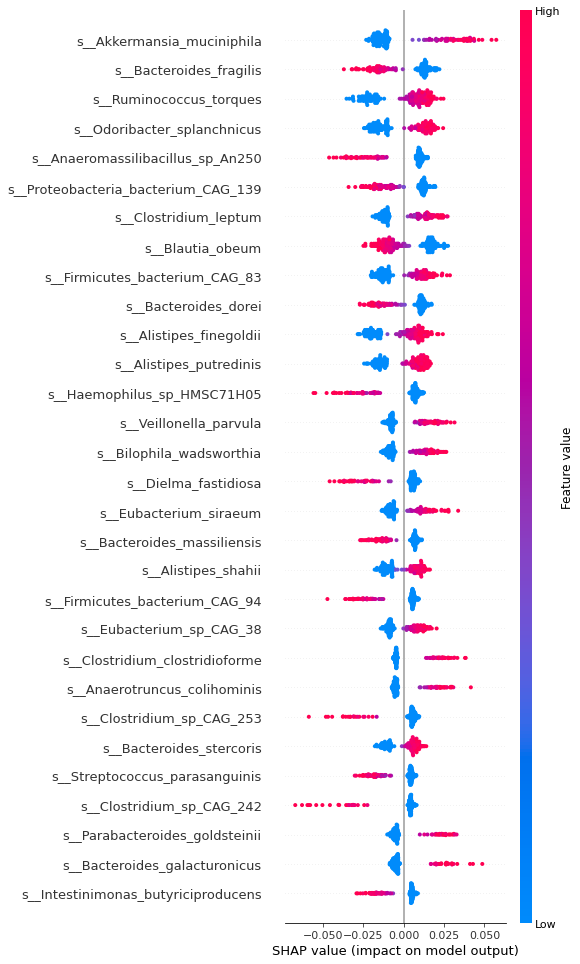

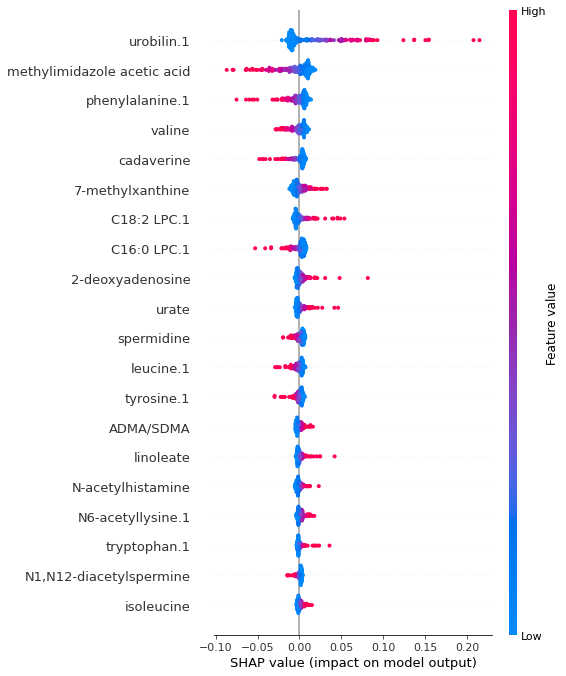

In [7]:
shap.initjs()
shap.summary_plot(shap_values[0][:,:578], pd.DataFrame(array(co_input.cpu()),columns = combined_columns).iloc[:,:578], max_display = 30, show = False)
plt.savefig('keymg_30.svg')
plt.show()
shap.summary_plot(shap_values[0][:,578:-2], pd.DataFrame(array(co_input.cpu()),columns = combined_columns).iloc[:,578:-2], max_display = 20, show = False)
plt.savefig('keymb_20.svg')
plt.show()

In [8]:
if os.path.isfile("co_UC_mg_important_fe_all.txt") == False:
    # 计算平均的绝对值
    mean_abs_shap_values = np.mean(np.abs(shap_values[0]), axis=0)
    
    # 获取特征排名
    feature_ranking = np.argsort(-mean_abs_shap_values)
    
    #按排名打印特征
    mg_fe_all = open('co_UC_mg_important_fe_all.txt',mode='a')
    mb_fe_all = open('co_UC_mb_important_fe_all.txt',mode='a')
    combined_columns = metagenomics.columns.to_list() + metabolomics.columns.to_list()
    combined_columns[:578] = [col.split('|s__', 1)[1] for col in combined_columns[:578]]
    for j in range(len(feature_ranking)):
        if feature_ranking[j] < 578:
            mg_fe_all.writelines(str(feature_ranking[j])+'\t'+combined_columns[feature_ranking[j]]+'\n')
        elif feature_ranking[j] <578+596:
            mb_fe_all.writelines(str(feature_ranking[j]-578)+'\t'+combined_columns[feature_ranking[j]]+'\n')
    mg_fe_all.close()
    mb_fe_all.close()
else:
    print("load existing shap important feature")

load existing shap important feature


(207, 1176)


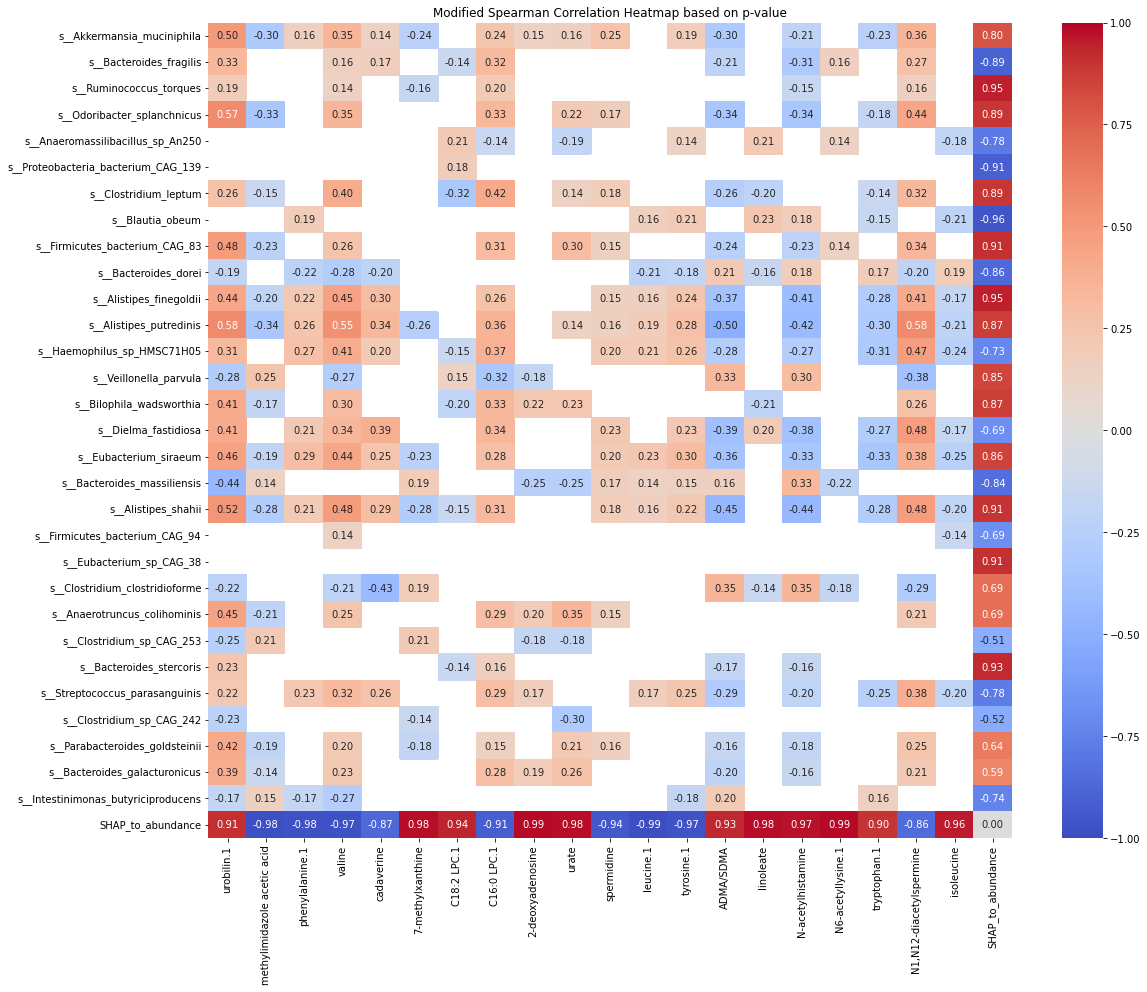

In [12]:
#取shap排名前二十的菌和代谢物用shap值作斯皮尔曼相关性分析，画聚类热力图
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# 加载CSV文件
df = pd.read_csv('co_UC_shap_values.csv', index_col=0)

# 选择"label"列值为-1的行
#selected_rows = df[df['label'] == -1]
selected_rows = df
print(selected_rows.shape)

# 提取特征列
txt_file = "co_UC_mg_important_fe_all.txt"
num = 0
mg_selected_columns = []
with open(txt_file, "r") as txt_file:
    for line in txt_file:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            column_number = int(parts[0])
            if column_number < 578:
                mg_selected_columns.append(column_number)
                num += 1
                if num == 30:
                    break
                    
txt_file = "co_UC_mb_important_fe_all.txt"
num = 0
mb_selected_columns = []
with open(txt_file, "r") as txt_file:
    for line in txt_file:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            column_number = int(parts[0])
            if column_number < 596:
                mb_selected_columns.append(column_number)
                num += 1
                if num == 20:
                    break

mb_selected_columns = [578+index for index in mb_selected_columns]
mg_features = selected_rows.iloc[:, mg_selected_columns]
mb_features = selected_rows.iloc[:, mb_selected_columns]

# 初始化相关性系数矩阵
num_mg_features = len(mg_features.columns)
num_mb_features = len(mb_features.columns)
correlation_matrix_spearman = np.zeros((num_mg_features+1, num_mb_features+1))
p_value_matrix_spearman = np.zeros((num_mg_features+1, num_mb_features+1))

# 计算相关性系数
for i, feature1 in enumerate(mg_features.columns):
    for j, feature2 in enumerate(mb_features.columns):
        correlation_spearman, p_value_spearman = stats.spearmanr(mg_features[feature1], mb_features[feature2])
        correlation_matrix_spearman[i, j] = correlation_spearman
        p_value_matrix_spearman[i, j] = p_value_spearman

#shap（贡献概率值）与原始丰度相关性        
mg_abundance = metagenomics.reindex(df.index).iloc[:, mg_selected_columns]
for i, feature1 in enumerate(mg_features.columns):
    correlation_spearman, p_value_spearman = stats.spearmanr(mg_features[feature1], mg_abundance.iloc[:,i])
    correlation_matrix_spearman[i, 20] = correlation_spearman
    p_value_matrix_spearman[i, 20] = p_value_spearman

mb_selected_columns = [index-578 for index in mb_selected_columns]
mb_abundance = metabolomics.reindex(df.index).iloc[:, mb_selected_columns]
for j, feature2 in enumerate(mb_features.columns):
    correlation_spearman, p_value_spearman = stats.spearmanr(mb_features[feature2], mb_abundance.iloc[:,j])
    correlation_matrix_spearman[30, j] = correlation_spearman
    p_value_matrix_spearman[30, j] = p_value_spearman
    
    
# 设置p值阈值，例如，p值小于0.05
p_value_threshold = 0.05

# 根据p值修改热力图颜色块
correlation_matrix_modified = np.where(p_value_matrix_spearman < p_value_threshold, correlation_matrix_spearman, np.nan)

#增加shap正负性
#mb_shap = np.array([1,-1,-1,-1,-1,1,1,-1,1,-1,1,1,-1,1,-1,-1,1,-1,1,-1]) 
#correlation_matrix_modified = np.vstack([correlation_matrix_modified, mb_shap])
#mg_shap = np.array([1,1,1,1,-1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,np.nan]) 
#mg_shap = mg_shap.reshape(-1, 1)  # 将一维数组转换为二维列向量
#correlation_matrix_modified = np.hstack([correlation_matrix_modified, mg_shap])

# Create a heatmap with modified colors based on p-value
mg_label = mg_features.columns.tolist()
mg_label.append('SHAP_to_abundance')
mb_label = mb_features.columns.tolist()
mb_label.append('SHAP_to_abundance')

plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix_modified, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=mb_label, yticklabels=mg_label,vmin=-1,vmax=1)
plt.title('Modified Spearman Correlation Heatmap based on p-value')
plt.show()

<Figure size 1296x1296 with 0 Axes>

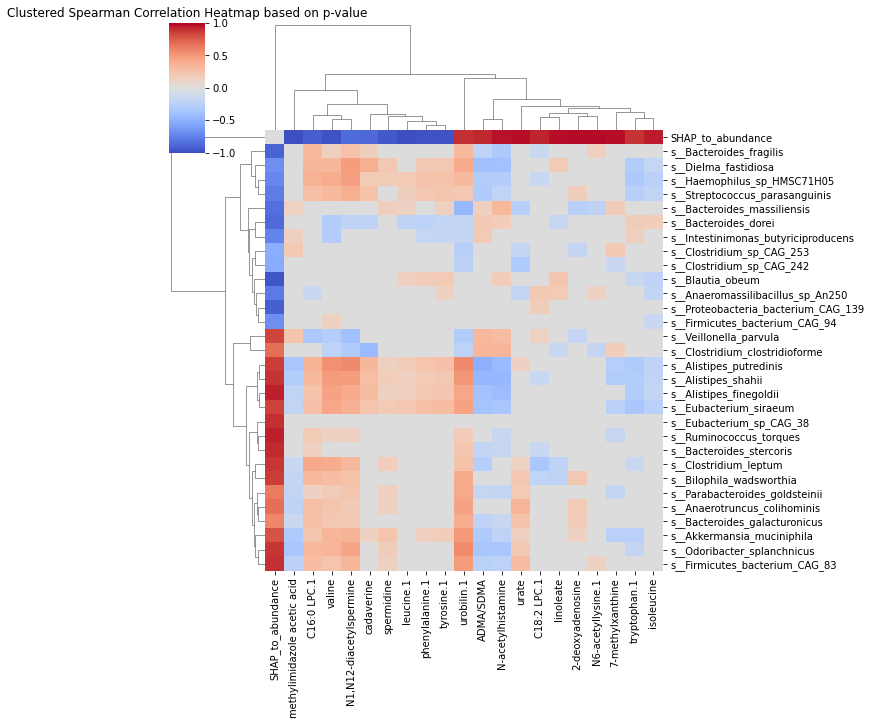

In [10]:
# 将NaN值替换为一个正数（例如0）
correlation_matrix_modified[np.isnan(correlation_matrix_modified)] = 0

# 绘制聚类图
plt.figure(figsize=(18, 18))
sns.clustermap(correlation_matrix_modified, cmap='coolwarm', xticklabels=mb_label, yticklabels=mg_label,vmin=-1,vmax=1)
plt.title('Clustered Spearman Correlation Heatmap based on p-value')
plt.show()

In [11]:
pd.DataFrame(correlation_matrix_modified,index = mg_label,columns = mb_label).to_csv("UC_SHAP_correlation_matrix_modified.csv", index=True)
pd.DataFrame(p_value_matrix_spearman,index = mg_label,columns = mb_label).to_csv("UC_SHAP_p_value_matrix_spearman.csv", index=True)